# Data_Cleaning, Data_Engineering, Data_Visualizations

## XLE Group

### 1. Load Data & Define Skeleton

**Explanation:** We load the STOCK_SENTIMENT_ENGINEERED_SURGICAL.csv to get the master dates. We also load the raw XLE file.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define Directories
raw_dir = r"D:\MS_Data_Science_Thesis\Data_Extraction\Raw_Data_Folder"
semi_clean_dir = r"D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets"

# 1. Load the "Skeleton" (The Stock Data)
stock_path = os.path.join(semi_clean_dir, "stock_senti_engineered_imputed_2.csv")
df_skeleton = pd.read_csv(stock_path)
df_skeleton['date'] = pd.to_datetime(df_skeleton['date'])

# Extract unique dates
unique_dates = pd.DataFrame(df_skeleton['date'].unique(), columns=['date']).sort_values('date')

# 2. Load Raw XLE Data
xle_path = os.path.join(raw_dir, "XLE_daily.csv")
df_xle_raw = pd.read_csv(xle_path)
df_xle_raw['date'] = pd.to_datetime(df_xle_raw['date'])
df_xle_raw = df_xle_raw.rename(columns={'xle_adj_close': 'XLE_Close'})

print(f"Skeleton Dates: {len(unique_dates)}")
print(f"Raw XLE Rows: {len(df_xle_raw)}")
df_xle_raw.head()

Skeleton Dates: 3443
Raw XLE Rows: 4052


,date,XLE_Close
0,2010-01-04,17.381092
1,2010-01-05,17.522953
2,2010-01-06,17.732790
3,2010-01-07,17.706190
4,2010-01-08,17.821457


### 2. Merge & Impute

**Explanation:** Left Join XLE onto the Skeleton.

**Critical Step:** XLE trades on the NYSE (same as your stocks). Missing data should be minimal (just occasional data provider gaps). ffill handles this perfectly.

In [18]:
# 1. Merge (Left Join)
df_xle_clean = pd.merge(unique_dates, df_xle_raw, on='date', how='left')

# 2. Impute (Forward Fill)
df_xle_clean['XLE_Close'] = df_xle_clean['XLE_Close'].ffill()
df_xle_clean['XLE_Close'] = df_xle_clean['XLE_Close'].bfill()

print(f"Merged XLE Shape: {df_xle_clean.shape}")
print(f"Missing Values: {df_xle_clean['XLE_Close'].isna().sum()}")

Merged XLE Shape: (3443, 2)
Missing Values: 0


### 3. Feature Engineering (XLE Specific)

**Explanation:** Calculating Returns, RSI, Volatility, and Trend Indicators.

In [21]:
# Helper Function for RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# 1. Log Returns (Sector Performance)
df_xle_clean['XLE_Log_Return'] = np.log(df_xle_clean['XLE_Close'] / df_xle_clean['XLE_Close'].shift(1))

# 2. RSI (14-Day Sector Momentum)
df_xle_clean['XLE_RSI'] = calculate_rsi(df_xle_clean['XLE_Close'])

# 3. Moving Averages (Sector Trend)
df_xle_clean['XLE_MA7'] = df_xle_clean['XLE_Close'].rolling(window=7).mean()
df_xle_clean['XLE_MA50'] = df_xle_clean['XLE_Close'].rolling(window=50).mean()

# 4. Sector Volatility (7-Day Rolling Std Dev)
df_xle_clean['XLE_Vol7'] = df_xle_clean['XLE_Log_Return'].rolling(window=7).std()

print("XLE Feature Engineering Complete.")
df_xle_clean.tail()

XLE Feature Engineering Complete.


,date,XLE_Close,XLE_Log_Return,XLE_RSI,XLE_MA7,XLE_MA50,XLE_Vol7
3438,2023-12-21,39.679710,0.003902,52.075536,39.303624,39.593896,0.012787
3439,2023-12-22,39.796783,0.002946,54.671837,39.533312,39.576606,0.012542
3440,2023-12-26,40.138649,0.008554,64.410897,39.651478,39.548248,0.007732
3441,2023-12-27,39.960701,-0.004443,69.479790,39.774041,39.510765,0.007580
3442,2023-12-28,39.351894,-0.015352,64.985976,39.764006,39.452386,0.009841


### 4. Save XLE Dataset

**Explanation:** Saving as XLE_engineered_6.csv.

In [24]:
output_path = os.path.join(semi_clean_dir, "XLE_engineered_6.csv")
df_xle_clean.to_csv(output_path, index=False)
print(f"Saved processed XLE data to: {output_path}")

Saved processed XLE data to: D:\MS_Data_Science_Thesis\Data_Cleaning\Semi_Clean_Datasets\XLE_engineered_6.csv


### 5. Overlay Visualization (Stock vs. Sector)

**Explanation:** 7 Graphs.

**Expectation:** You should see an extremely tight Positive Correlation. The lines should almost move in lockstep.

**Thesis Insight:** Look for gaps. If OXY diverges from XLE (e.g., OXY goes up while XLE goes down), that is a massive Alpha signal (company-specific news driving the price).

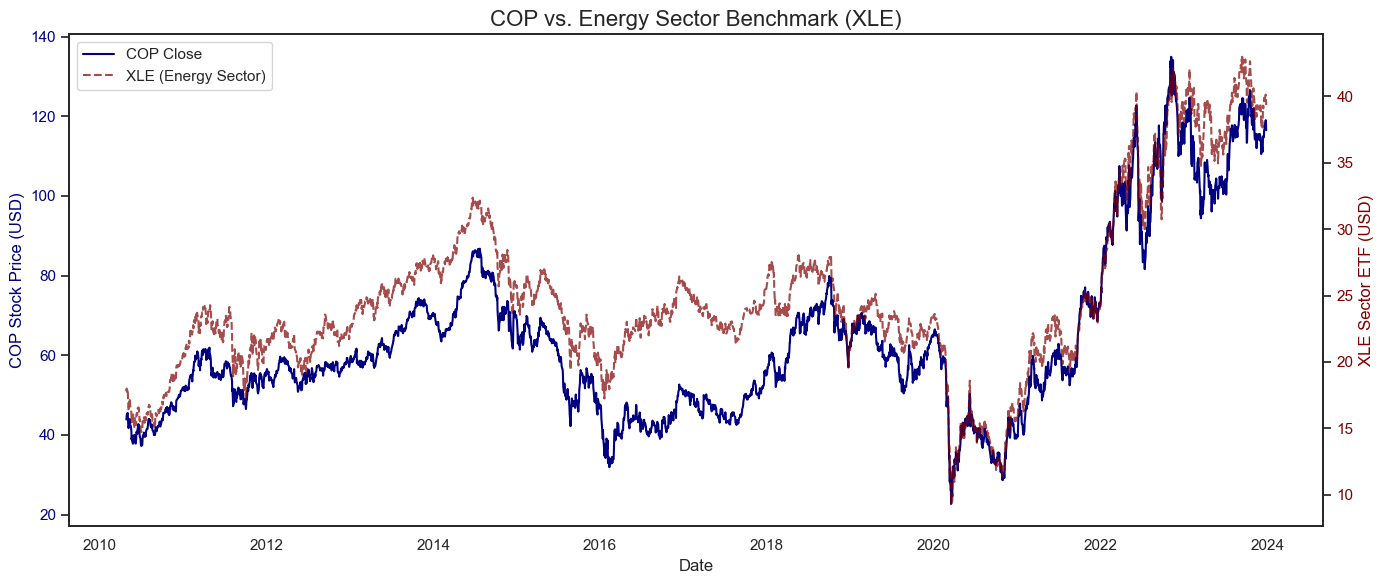

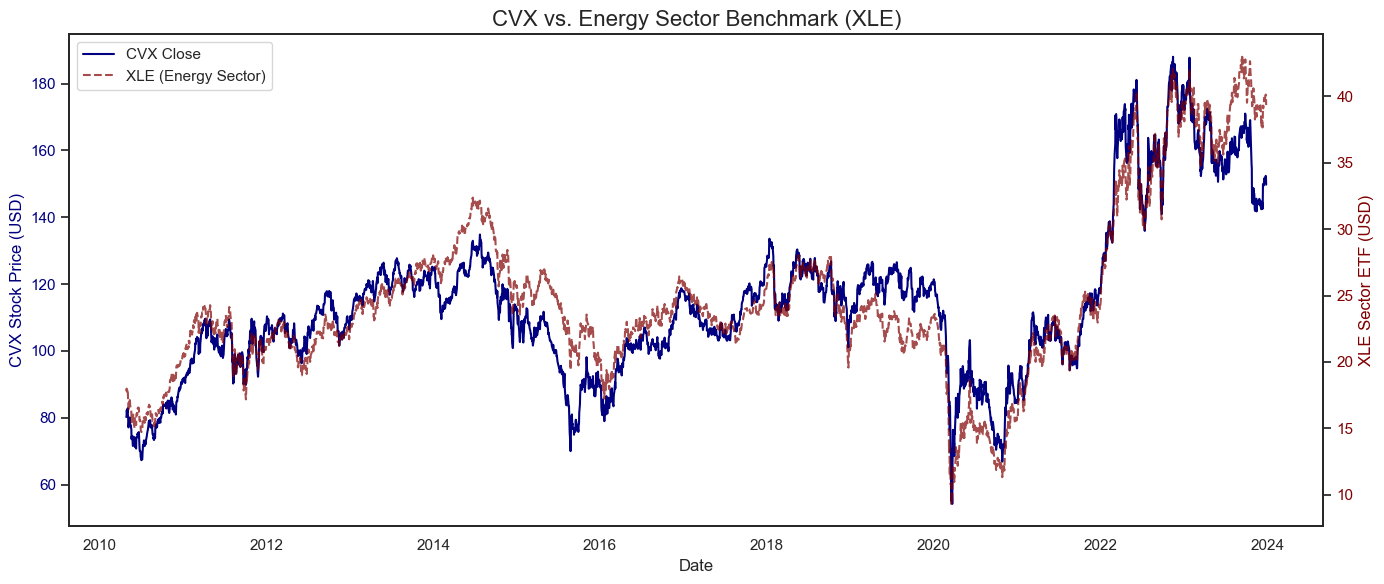

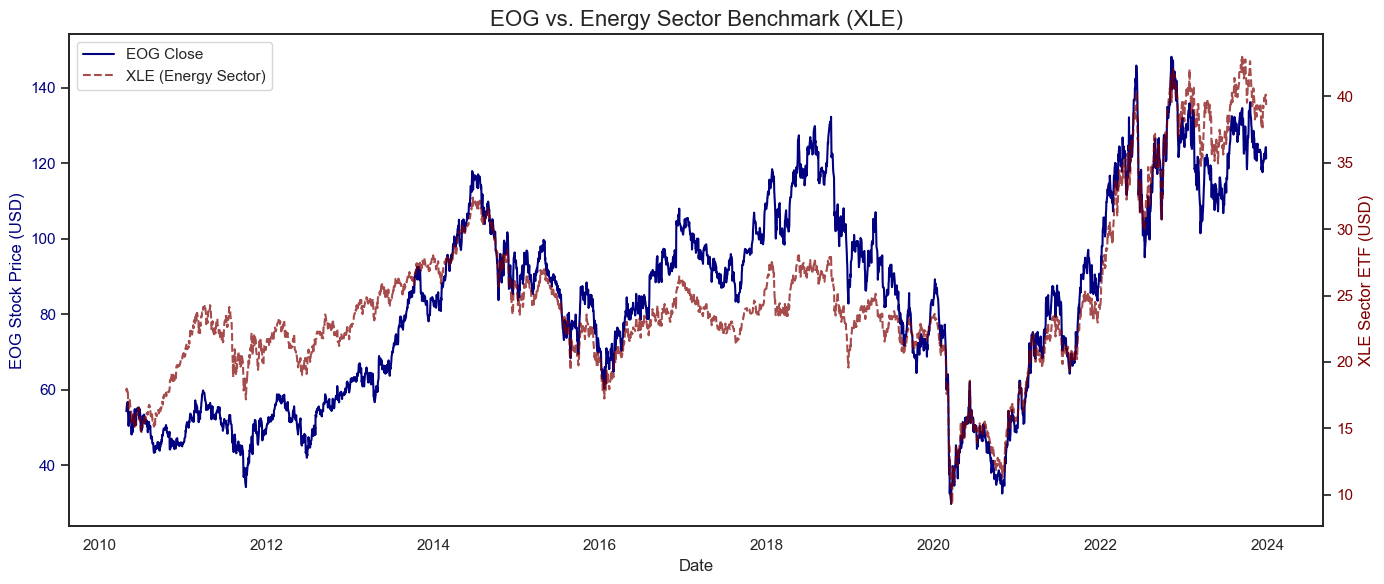

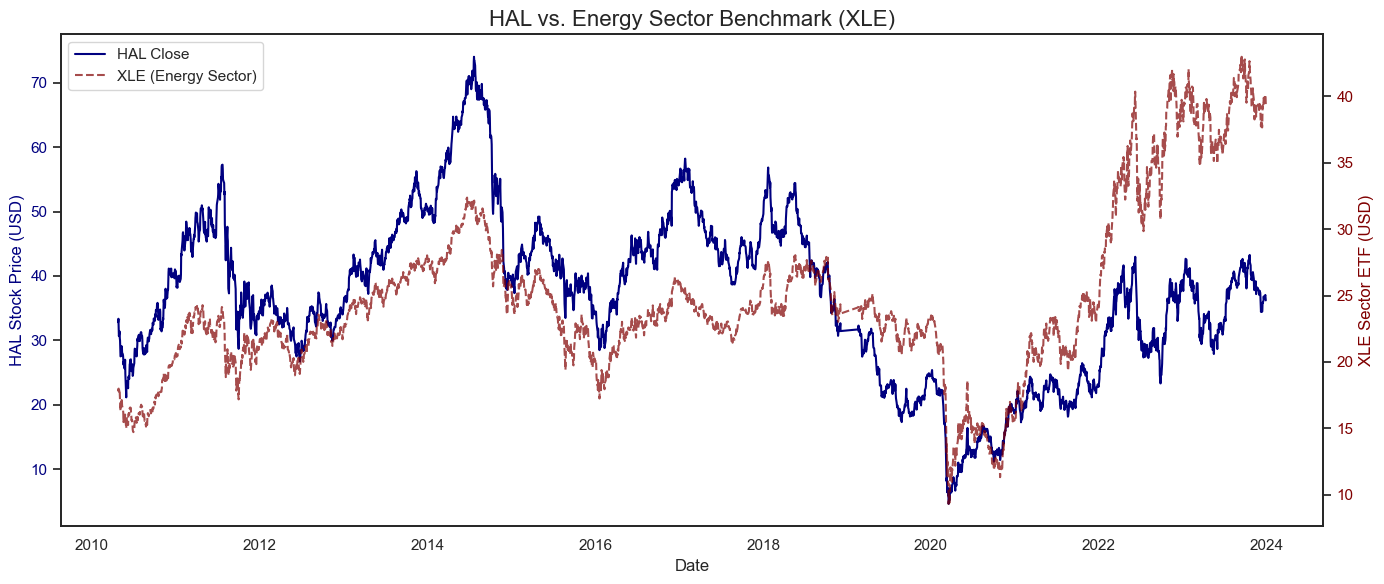

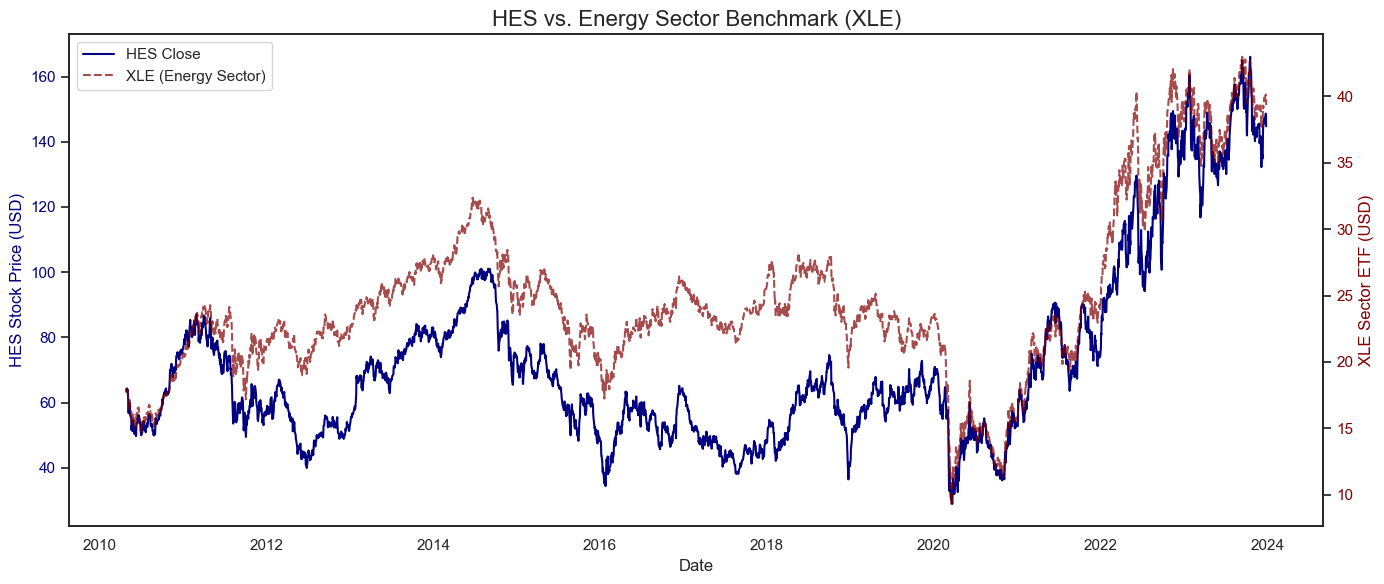

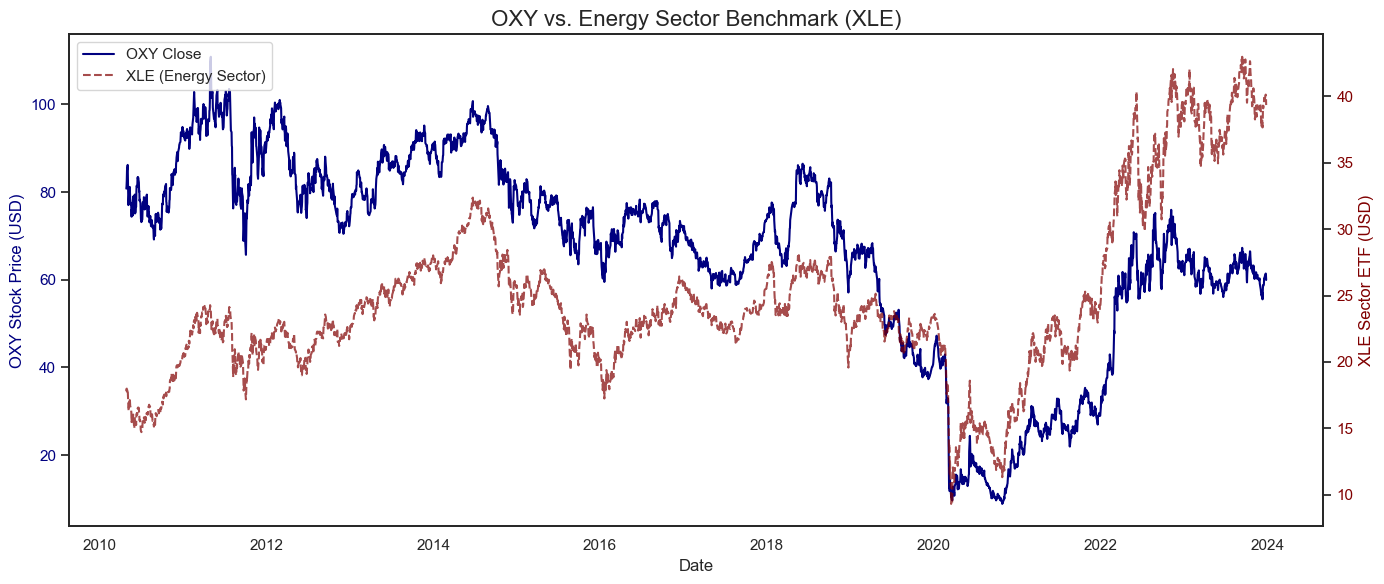

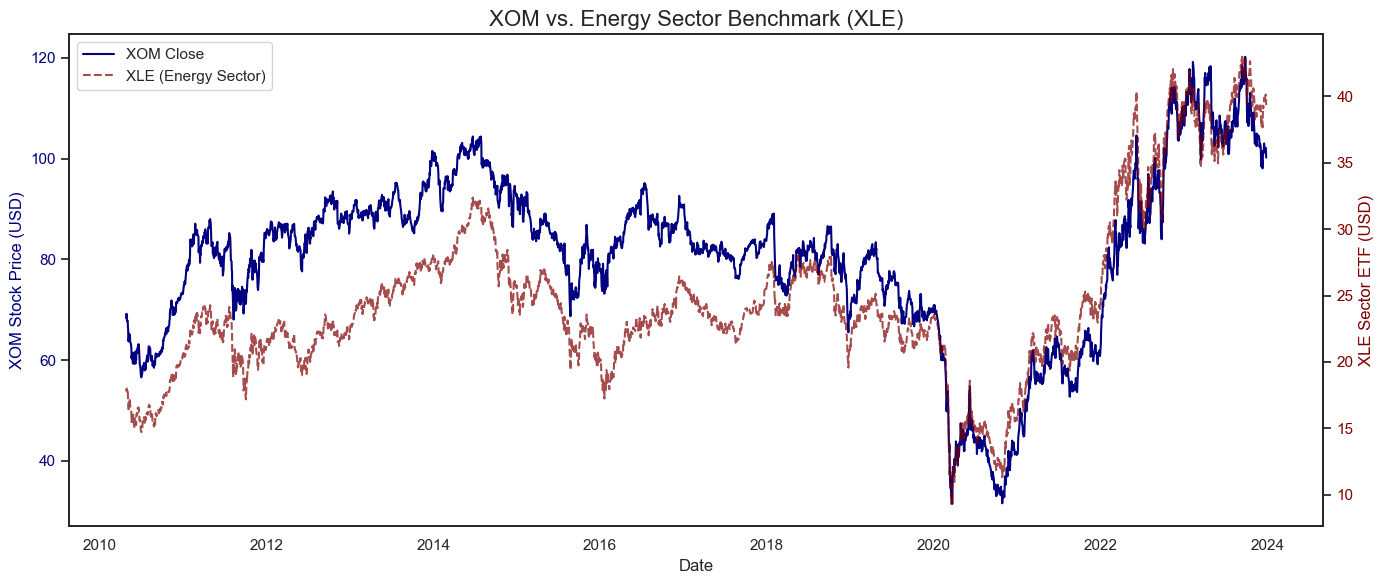

In [27]:
# Temporary merge for plotting
plot_df = pd.merge(df_skeleton, df_xle_clean, on='date', how='left')

tickers = plot_df['ticker'].unique()
sns.set(style="white")

for t in tickers:
    subset = plot_df[plot_df['ticker'] == t]
    
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. Stock Price (Left Axis)
    color1 = 'navy'
    ax1.set_xlabel('Date')
    ax1.set_ylabel(f'{t} Stock Price (USD)', color=color1, fontsize=12)
    ax1.plot(subset['date'], subset['close'], color=color1, label=f'{t} Close', linewidth=1.5)
    ax1.tick_params(axis='y', labelcolor=color1)
    
    # 2. XLE Price (Right Axis)
    ax2 = ax1.twinx()  
    color2 = 'maroon' # Maroon to represent the broad market/sector
    ax2.set_ylabel('XLE Sector ETF (USD)', color=color2, fontsize=12)
    ax2.plot(subset['date'], subset['XLE_Close'], color=color2, label='XLE (Energy Sector)', linestyle='--', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    plt.title(f"{t} vs. Energy Sector Benchmark (XLE)", fontsize=16)
    
    # Combined Legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
    
    plt.tight_layout()
    plt.show()